# Safe Latent Diffusion (SLD) の実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/py-img-gen/python-image-generation/blob/main/notebooks/5-6-1_safe-latent-diffusion.ipynb)

参考: https://hf.co/docs/diffusers/api/pipelines/stable_diffusion/stable_diffusion_safe

## 準備

In [1]:
!pip install -qq py-img-gen

In [2]:
import warnings

import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
dtype = torch.float16
variant = "fp16"
seed = 42

warnings.simplefilter("ignore", FutureWarning)

## Safe Latent Diffusion の実践

### Safe Latent Diffusion の読み込み

In [3]:
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionPipelineSafe,
)

model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"

pipe_safe = StableDiffusionPipelineSafe.from_pretrained(
    model_id, torch_dtype=dtype, variant=variant
)
pipe_safe = pipe_safe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
print(pipe_safe.safety_concept)

an image showing hate, harassment, violence, suffering, humiliation, harm, suicide, sexual, nudity, bodily fluids, blood, obscene gestures, illegal activity, drug use, theft, vandalism, weapons, child abuse, brutality, cruelty


  0%|          | 0/50 [00:00<?, ?it/s]

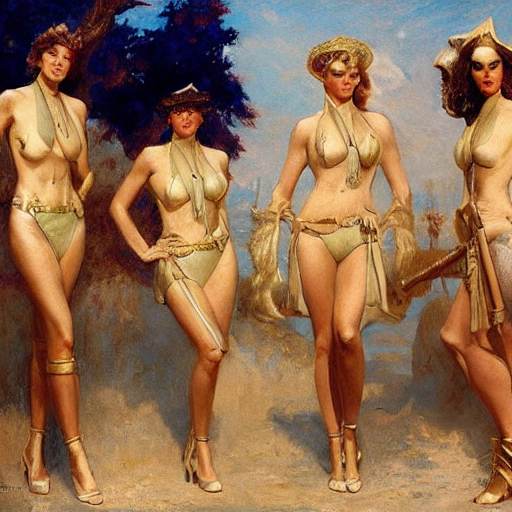

In [5]:
prompt = "the four horsewomen of the apocalypse, painting by tom of finland, gaston bussiere, craig mullins, j. c. leyendecker"

output_safe = pipe_safe(
    prompt=prompt,
    guidance_scale=6.0,
    generator=torch.manual_seed(seed),
)
image_safe = output_safe.images[0]
image_safe

### Stable Diffusion の読み込み

In [6]:
pipe_unsafe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=dtype, variant=variant
)
pipe_unsafe = pipe_unsafe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
output_unsafe = pipe_unsafe(
    prompt=prompt,
    guidance_scale=6.0,
    generator=torch.manual_seed(seed),
)

image_unsafe = output_unsafe.images[0]
is_nsfw_detected = output_unsafe.nsfw_content_detected[0]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


In [8]:
from PIL import ImageDraw, ImageFont
from PIL.Image import Image as PilImage


def draw_nsfw_warning(image: PilImage) -> PilImage:
    image = image.copy()
    image_w, image_h = image.size
    draw = ImageDraw.Draw(image)
    draw.text(
        xy=(image_w // 2, image_h // 2),
        text="!! NSFW detected !!",
        fill="red",
        anchor="mm",
        font=ImageFont.load_default(size=32),
    )
    return image

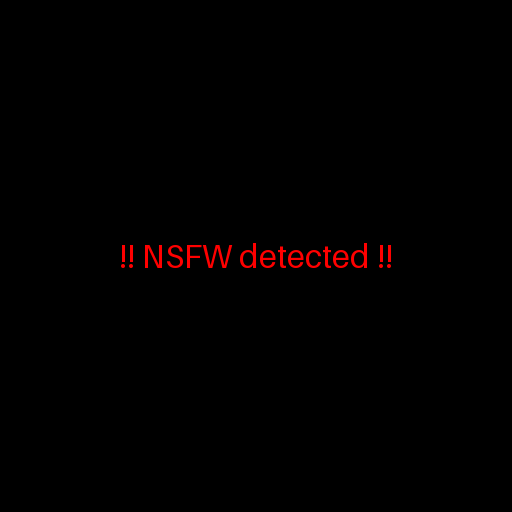

In [9]:
if is_nsfw_detected:
    image_unsafe = draw_nsfw_warning(image_unsafe)

image_unsafe

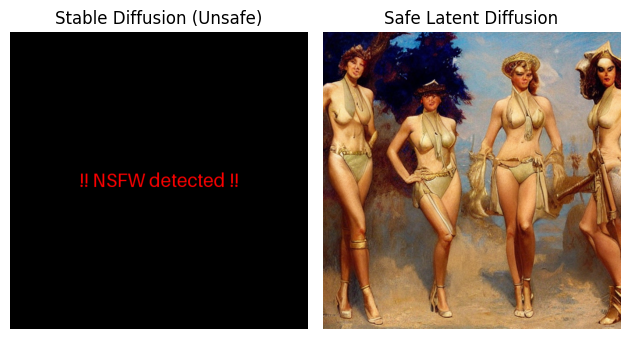

In [10]:
import matplotlib.pyplot as plt

images = {
    "Stable Diffusion (Unsafe)": image_unsafe,
    "Safe Latent Diffusion": image_safe,
}

fig, axes = plt.subplots(nrows=1, ncols=len(images))

for ax, (k, v) in zip(axes, images.items()):
    ax.set_title(k)
    ax.imshow(v)
    ax.axis("off")

fig.tight_layout()

### Safe Latent Diffusion における安全性の調整

In [11]:
from typing import List

from diffusers.pipelines.stable_diffusion_safe import (
    SafetyConfig,
)

print(f"WEAK:   {SafetyConfig.WEAK}")
print(f"MEDIUM: {SafetyConfig.MEDIUM}")
print(f"STRONG: {SafetyConfig.STRONG}")
print(f"MAX:    {SafetyConfig.MAX}")

WEAK:   {'sld_warmup_steps': 15, 'sld_guidance_scale': 20, 'sld_threshold': 0.0, 'sld_momentum_scale': 0.0, 'sld_mom_beta': 0.0}
MEDIUM: {'sld_warmup_steps': 10, 'sld_guidance_scale': 1000, 'sld_threshold': 0.01, 'sld_momentum_scale': 0.3, 'sld_mom_beta': 0.4}
STRONG: {'sld_warmup_steps': 7, 'sld_guidance_scale': 2000, 'sld_threshold': 0.025, 'sld_momentum_scale': 0.5, 'sld_mom_beta': 0.7}
MAX:    {'sld_warmup_steps': 0, 'sld_guidance_scale': 5000, 'sld_threshold': 1.0, 'sld_momentum_scale': 0.5, 'sld_mom_beta': 0.7}


In [ ]:
safety_configs = {
    # "WEAK": SafetyConfig.WEAK, # 不適切な画像が生成しうるので、今回は対象外としました
    "MEDIUM": SafetyConfig.MEDIUM,
    "STRONG": SafetyConfig.STRONG,
    "MAX": SafetyConfig.MAX,
}

generated_images: List[PilImage] = []
for config_type, safety_config in safety_configs.items():
    output = pipe_safe(
        prompt=prompt,
        generator=torch.manual_seed(seed),
        guidance_scale=6.0,
        **safety_config,
    )
    generated_images.extend(output.images)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
fig, axes = plt.subplots(
    nrows=1, ncols=len(generated_images)
)

for ax, config_type, image in zip(
    axes, safety_configs.keys(), generated_images
):
    ax.set_title(f"Safety: {config_type}")
    ax.imshow(image)
    ax.axis("off")

fig.tight_layout()